# **Blog Post Link**

https://medium.com/@ahmadjonovbekmurod06/my-mobapp-studio-29b859f1948a

# **My Mobapp Studio**

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import plotly.express as px

## Load dataset

In [2]:
def load_dataset():
    dataset_url = pd.read_csv("/googleplaystore.csv")
    return dataset_url

In [3]:
dataset = load_dataset()
dataset

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10836,Sya9a Maroc - FR,FAMILY,4.5,38,53M,"5,000+",Free,0,Everyone,Education,"July 25, 2017",1.48,4.1 and up
10837,Fr. Mike Schmitz Audio Teachings,FAMILY,5.0,4,3.6M,100+,Free,0,Everyone,Education,"July 6, 2018",1.0,4.1 and up
10838,Parkinson Exercices FR,MEDICAL,NaN,3,9.5M,"1,000+",Free,0,Everyone,Medical,"January 20, 2017",1.0,2.2 and up
10839,The SCP Foundation DB fr nn5n,BOOKS_AND_REFERENCE,4.5,114,Varies with device,"1,000+",Free,0,Mature 17+,Books & Reference,"January 19, 2015",Varies with device,Varies with device


## Print summarize

In [4]:
def print_summarize_dataset(dataset):
    print(f"Dataset shape: {str(dataset.shape)[1:-1]}")

    print("\n\nFirst 10 rows of dataset:")
    display(dataset.head(10))

    print("\n\nDataset info:\n")
    display(dataset.info())

    print("\n\nNaN values caunt:")
    nan = dataset.isna().sum()
    display(pd.DataFrame({'column' : nan.index, 'caunt' : nan.values}))


In [5]:
print_summarize_dataset(dataset)

Dataset shape: 10841, 13


First 10 rows of dataset:


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
5,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up
6,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,3.8,178,19M,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up
7,Infinite Painter,ART_AND_DESIGN,4.1,36815,29M,"1,000,000+",Free,0,Everyone,Art & Design,"June 14, 2018",6.1.61.1,4.2 and up
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33M,"1,000,000+",Free,0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up
9,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,4.7,121,3.1M,"10,000+",Free,0,Everyone,Art & Design;Creativity,"July 3, 2018",2.8,4.0.3 and up




Dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


None



NaN values caunt:


,column,caunt
0,App,0
1,Category,0
2,Rating,1474
3,Reviews,0
4,Size,0
5,Installs,0
6,Type,1
7,Price,0
8,Content Rating,1
9,Genres,0


## Clean dataset

In [6]:
def clean_dataset(dataset):

  dataset = dataset.drop_duplicates(subset=['App'], keep='first')

  dataset = dataset[dataset['Category'] != '1.9']
  dataset.loc[:, 'Category'] = dataset['Category'].str.replace('_', ' ').str.capitalize()

  dataset.dropna(subset=['Rating'], inplace=True)

  dataset['Reviews'] = dataset['Reviews'].astype(int)

  dataset['Size'] = dataset['Size'].str.replace('k', '').str.replace('M', '')
  dataset['Size'].replace('Varies with device', np.nan, inplace=True)
  dataset['Size'] = pd.to_numeric(dataset['Size'], errors='coerce')
  dataset['Size'].fillna(dataset['Size'].mean(), inplace=True)

  dataset['Installs'] = dataset['Installs'].str.replace(r',|\+', '', regex = True).astype(int)

  dataset['Type'] = dataset['Type'].replace({'Free': 1, 'Paid': 0}).astype(int)
  dataset.rename(columns={'Type': 'Free'}, inplace=True)

  dataset['Price'] = dataset['Price'].str.replace('$', '').astype(float)

  dataset['Content Rating'] = dataset['Content Rating'].str.replace('+', '')

  dataset['Genres'] = dataset['Genres'].replace({'&': 'and', ';': ', ', 'Education;Education': 'Education'}, regex=True)

  dataset['Last Updated'] = pd.to_datetime(dataset['Last Updated'])

  dataset.dropna(axis=0, inplace=True)
  dataset.reset_index(drop=True, inplace=True)

  return dataset

In [7]:

dataset = clean_dataset(dataset)
dataset

<ipython-input-6-e9fc607a1bc7>:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dataset['Price'] = dataset['Price'].str.replace('$', '').astype(float)
<ipython-input-6-e9fc607a1bc7>:24: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dataset['Content Rating'] = dataset['Content Rating'].str.replace('+', '')


,App,Category,Rating,Reviews,Size,Installs,Free,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,Art and design,4.1,159,19.000000,10000,1,0.0,Everyone,Art and Design,2018-01-07,1.0.0,4.0.3 and up
1,Coloring book moana,Art and design,3.9,967,14.000000,500000,1,0.0,Everyone,"Art and Design, Pretend Play",2018-01-15,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",Art and design,4.7,87510,8.700000,5000000,1,0.0,Everyone,Art and Design,2018-08-01,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,Art and design,4.5,215644,25.000000,50000000,1,0.0,Teen,Art and Design,2018-06-08,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,Art and design,4.3,967,2.800000,100000,1,0.0,Everyone,"Art and Design, Creativity",2018-06-20,1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8185,FR Calculator,Family,4.0,7,2.600000,500,1,0.0,Everyone,Education,2017-06-18,1.0.0,4.1 and up
8186,Sya9a Maroc - FR,Family,4.5,38,53.000000,5000,1,0.0,Everyone,Education,2017-07-25,1.48,4.1 and up
8187,Fr. Mike Schmitz Audio Teachings,Family,5.0,4,3.600000,100,1,0.0,Everyone,Education,2018-07-06,1.0,4.1 and up
8188,The SCP Foundation DB fr nn5n,Books and reference,4.5,114,37.401281,1000,1,0.0,Mature 17,Books and Reference,2015-01-19,Varies with device,Varies with device


## Describing

In [8]:
dataset.describe()

,Rating,Reviews,Size,Installs,Free,Price
count,8190.000000,8.190000e+03,8190.000000,8.190000e+03,8190.000000,8190.000000
mean,4.173321,2.554354e+05,37.422637,9.171613e+06,0.926496,1.038342
std,0.536691,1.986309e+06,90.191990,5.827170e+07,0.260978,16.864040
min,1.000000,1.000000e+00,1.000000,1.000000e+00,0.000000,0.000000
25%,4.000000,1.260000e+02,6.800000,1.000000e+04,1.000000,0.000000
50%,4.300000,3.009500e+03,20.000000,1.000000e+05,1.000000,0.000000
75%,4.500000,4.391425e+04,37.401281,1.000000e+06,1.000000,0.000000
max,5.000000,7.815831e+07,994.000000,1.000000e+09,1.000000,400.000000


## Plotting histograms

In [9]:
def print_histograms(dataset):
    dataset.hist(column = ['Rating', 'Reviews', 'Size', 'Free', 'Price', 'Installs'], bins = 20, figsize=(15, 15))
    plt.show()

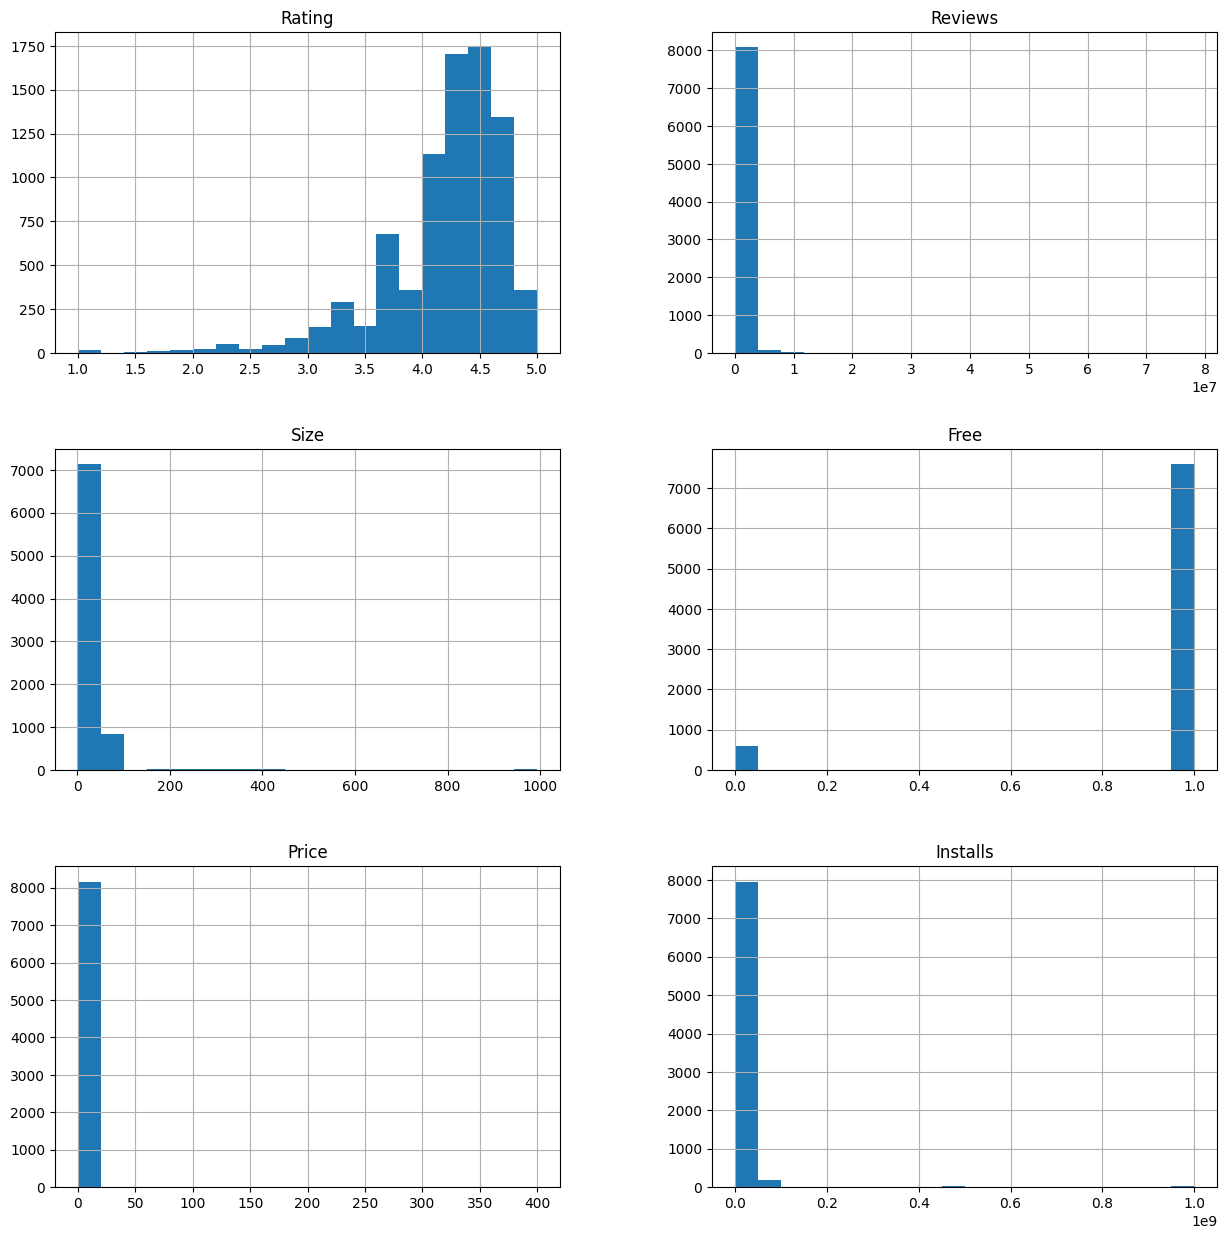

In [10]:
print_histograms(dataset)

## Compute correlation matrix

In [11]:
def compute_correlations_matrix(dataset, columns=None):
    plt.figure(figsize=(10, 5))

    correlation_matrix = dataset[columns].corr()
    sns.heatmap(data=correlation_matrix, annot=True, linewidth=0.5, cmap='coolwarm')

    plt.title("Correlation Matrix")
    plt.show()

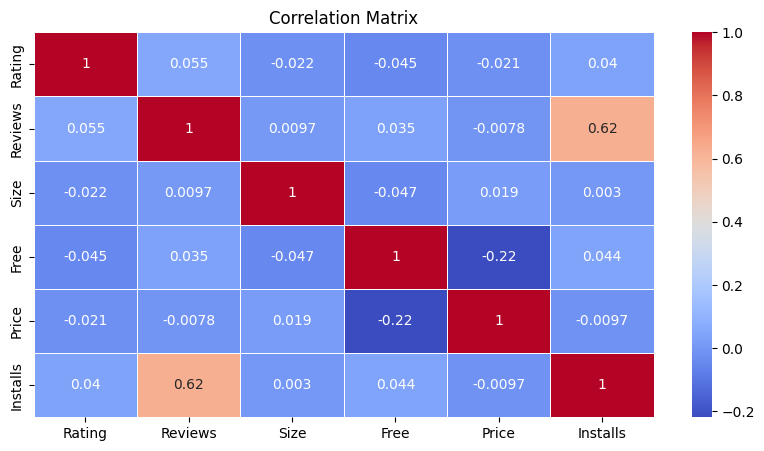

In [12]:
selected_columns = ['Rating', 'Reviews', 'Size', 'Free', 'Price', 'Installs']
compute_correlations_matrix(dataset, columns=selected_columns)

## Top apps type

In [13]:
def top_apps_type(dataset):
    categories = ['Game', 'Family', 'Tools']
    fig = px.bar()

    for category in categories:
        subset = dataset[dataset['Category'] == category]
        count = subset['Free'].value_counts()
        free = count.get(1, 0)
        paid = count.get(0, 0)

        fig.add_trace(px.bar(x=[f'{category} - Free', f'{category} - Paid'], y=[free, paid],
                             text=[f'{free:.1f}', f'{paid:.1f}']).data[0])

    fig.update_layout(title='Top Apps by Type', barmode='group')
    fig.show()

In [14]:
top_apps_type(dataset)

## Paid apps

In [15]:
def paid_apps(dataset):
    family = dataset[(dataset['Category'] == 'Family') & (dataset['Free'] == 0)]

    family = family.sort_values('Installs', ascending=False).head(20)

    fig = px.bar(family, y='App', x='Installs', orientation='h',
                 color='Installs', color_continuous_scale='viridis',
                 title='Top 10 Paid Apps in Family Category', labels={'Installs': 'Number of Installs'})

    fig.update_layout(height=800, width=1000)
    fig.show()


In [16]:
paid_apps(dataset)

## Pie Installs

In [17]:
def pie_installs(dataset):
    categories = dataset['Category'].unique()

    count = []
    for category in categories:
        count.append(dataset[dataset['Category'] == category]['Installs'].sum())

    count_df = pd.DataFrame({'Category': categories, 'Count': count})
    count_df.sort_values('Count', ascending=False, inplace=True)
    count_df = count_df.head(15)

    fig = px.pie(count_df, names='Category', values='Count', title='Percentage of Total Installs by Category', labels={'Category': 'Categories', 'Count': 'Installs'},hole=0.3 )
    fig.update_traces(textinfo='percent+label', pull=[0.1] * 15, rotation=90)
    fig.update_layout(width=1000, height=800)

    fig.show()


In [18]:
pie_installs(dataset)

## Pie Category Apps

---



In [19]:
def pie_category_apps(dataset):
    category_counts = dataset['Category'].value_counts().head(10)
    print(category_counts)

    fig = px.pie(category_counts, values=category_counts, names=category_counts.index, title='Number of Apps by Category', hole=0.3)
    fig.update_traces(textinfo='percent+label', pull=[0.1] * 15, rotation=90)
    fig.update_layout(width=1000, height=800)

    fig.show()

In [20]:
pie_category_apps(dataset)

Family             1607
Game                912
Tools               717
Finance             302
Productivity        301
Lifestyle           301
Personalization     296
Medical             290
Business            263
Photography         263
Name: Category, dtype: int64


## Top price family apps

In [21]:
def top_price_family_apps(dataset):
    a = dataset.sort_values('Installs', ascending=False)
    free_rows = a[a['Free'] == 0]
    family_free_rows = free_rows[free_rows['Category'] == 'Family']

    top_15_apps = family_free_rows.head(15)

    fig = px.pie(top_15_apps, values='Installs', names='App', title='Family apps', hole=0.3)
    fig.update_traces(textinfo='percent+label', pull=[0.1] * 15, rotation=90)
    fig.update_layout(width=1000, height=800)

    fig.show()

In [22]:
top_price_family_apps(dataset)

## Plot bar expensive apps

In [23]:
def plot_bar_expensive_apps(dataset, top_n=15, palette='viridis'):
    paid_apps = dataset[dataset['Free'] == 0]

    df = paid_apps.groupby('Category')['Price'].mean().dropna().reset_index().sort_values('Price', ascending=False).head(top_n)

    fig = px.bar(df, x='Category', y='Price', color='Price', color_continuous_scale=palette,
                 labels={'Price': 'Mean Price', 'Category': 'Category'},
                 title=f"Top {top_n} Categories with Expensive Apps (Paid)")

    fig.update_layout(showlegend=False)

    fig.show()

In [24]:
plot_bar_expensive_apps(dataset, top_n=15, palette='viridis')

## Family apps ratings

In [25]:
def family_apps_ratings(dataset, top_n=20):
    family_apps = dataset[dataset['Category'] == 'Family'].sort_values(['Reviews', 'Installs', 'Rating'], ascending=False).head(top_n)

    fig = px.bar(family_apps, x='Reviews', y='App', orientation='h', color='Reviews', color_continuous_scale='viridis',
                 labels={'Reviews': 'Reviews', 'App': 'App'},
                 title=f"Top {top_n} Family Apps by Reviews")

    fig.update_layout(height=600, width=1200)

    fig.show()

In [26]:
family_apps_ratings(dataset)